# NASA 데이터셋 분석

In [218]:
import scipy.io  #  mat file read 
import tensorflow as tf
from sklearn.metrics import accuracy_score
from numpy import argmax
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import os

In [219]:
# 한글 폰트 깨짐 방지 코드
import matplotlib as mpl
import matplotlib.font_manager as fm

# print(mpl.matplotlib_fname()) # 디렉토리 확인하기

normal_font = fm.FontEntry(fname=os.path.join('/home/srjung/.local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc', 'NanumGothic.otf'), name='NanumGothic')
fm.fontManager.ttflist.append(normal_font)
mpl.rcParams['font.family'] = normal_font.name


bold_font = fm.FontEntry(fname=os.path.join('/home/srjung/.local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc', 'NanumBoldGothic.otf'), name='NanumBoldGothic')
fm.fontManager.ttflist.append(bold_font)

plt.rcParams['axes.unicode_minus'] = False

## 데이터셋 불러오기

In [315]:
trainset = [("B0018","Battery_Data_Set"), ("B0005","Battery_Data_Set"), ("B0006","Battery_Data_Set")]
testset = [("B0007","Battery_Data_Set")]

In [316]:
def get_matData(dataName_and_set):
    mat_name = dataName_and_set[0]
    dataset = dataName_and_set[1]

    if dataset == "Battery_Data_Set":

        path = '../dataset'
        file_name = mat_name + ".mat"
        mat_datas = scipy.io.loadmat(path + '/' + file_name)
        mat_datas = mat_datas[mat_name]['cycle'][0][0][0]

        charge_data = []
        charge_time = []
        discharge_data = []
        discharge_time = []
        for mat_data in mat_datas:
            if mat_data['type'][0] == 'impedance':
                continue
            else:
                tmp = {}
                for dict in mat_data['data'].dtype.names:
                    tmp[dict] = mat_data['data'][dict][0][0][0] # 데이터 배열이 이상하므로 맞춰줌
                if mat_data['type'][0] == 'charge':
#                     time["start_time"] = mat_data['time'][0]
                    charge_time.append(mat_data['time'][0])
                    charge_data.append(tmp)
                elif mat_data['type'][0] == 'discharge':
                    discharge_time.append(mat_data['time'][0])
                    discharge_data.append(tmp)
                    
        return charge_data, discharge_data, charge_time, discharge_time

In [317]:
# train dataset 생성
train_data = {}
train_data['charge'] = []
train_data['charge_time'] = []
train_data['discharge'] = []
train_data['discharge_time'] = []
for td in trainset:
    charge_data, discharge_data, charge_time, discharge_time = get_matData(td)  # 4개 데이터셋
    train_data['charge_time'].append(charge_time)
    train_data['discharge_time'].append(discharge_time)
    train_data['charge'].append(charge_data)
    train_data['discharge'].append(discharge_data)

# test dataset 생성
test_data = {}
test_data['charge'] = []
test_data['charge_time'] = []
test_data['discharge'] = []
test_data['discharge_time'] = []
for td in testset:
    charge_data, discharge_data,  charge_time, discharge_time = get_matData(td) 
    test_data['charge_time'].append(charge_time)
    test_data['discharge_time'].append(discharge_time)
    test_data['charge'].append(charge_data)
    test_data['discharge'].append(discharge_data)

# 충전 구간 분석

- 충전 구간 주기: 2-3초

In [248]:
dataset = {}
for j in range(len(trainset)):
    df_size = []
    for i in range(len(train_data['charge'][j])-1):
        df = pd.DataFrame(train_data['charge'][j][i])
        df_size.append(df.shape[0])
    dataset["train%s"%j] = df_size
    
for j in range(len(testset)):
    df_size = []
    for i in range(len(test_data['charge'][j])-1):
        df = pd.DataFrame(test_data['charge'][j][i])
        df_size.append(df.shape[0])
    dataset["test%s"%j] = df_size

In [291]:
print("< 충전 구간 >\n")
print("사이클별 B0018 학습 데이터 크기: %s\n"%(dataset['train0']))
print("사이클별 B0005 학습 데이터 크기: %s\n"%(dataset['train1']))
print("사이클별 B0006 학습 데이터의 크기: %s\n"%(dataset['train2']))
print("사이클별 B0007 테스트 데이터의 크기: %s\n"%(dataset['test0']))

< 충전 구간 >

사이클별 B0018 학습 데이터 크기: [366, 362, 358, 355, 354, 351, 348, 345, 342, 343, 340, 337, 334, 331, 330, 327, 325, 323, 320, 317, 315, 314, 311, 309, 312, 310, 308, 306, 304, 302, 300, 298, 296, 295, 292, 281, 289, 287, 286, 288, 286, 283, 281, 279, 277, 301, 298, 295, 292, 290, 289, 286, 284, 281, 280, 279, 279, 276, 273, 271, 269, 267, 265, 263, 261, 259, 257, 256, 253, 252, 255, 253, 251, 249, 247, 245, 243, 242, 241, 239, 238, 236, 235, 234, 233, 237, 234, 232, 230, 229, 230, 229, 227, 226, 224, 223, 222, 221, 219, 216, 218, 217, 216, 215, 214, 223, 222, 221, 208, 217, 205, 215, 214, 213, 212, 211, 209, 208, 207, 201, 212, 211, 209, 208, 206, 206, 204, 204, 204, 202, 201]

사이클별 B0005 학습 데이터 크기: [197, 196, 195, 194, 194, 195, 195, 191, 190, 190, 189, 187, 186, 186, 185, 184, 183, 182, 182, 192, 190, 189, 187, 188, 184, 184, 183, 183, 183, 182, 371, 365, 363, 362, 360, 360, 359, 357, 356, 355, 355, 354, 179, 354, 352, 350, 349, 356, 356, 353, 351, 350, 349, 349, 348, 347, 346, 34

In [104]:
print("B0018 학습 데이터의 충전 사이클 수: %d"%len(train_data['charge'][0]))
print("B0005 학습 데이터의 충전 사이클 수: %d"%len(train_data['charge'][1]))
print("B0006 학습 데이터의 충전 사이클 수: %d"%len(train_data['charge'][2]))
print("B0007 테스트 데이터의 충전 사이클 수: %d"%len(test_data['charge'][0]))

B0018 학습 데이터의 충전 사이클 수: 134
B0005 학습 데이터의 충전 사이클 수: 170
B0006 학습 데이터의 충전 사이클 수: 170
B0007 테스트 데이터의 충전 사이클 수: 170


In [136]:
time_1 = list(map(int,train_data['charge_time'][0][0]))
time_e1 = list(map(int,train_data['charge_time'][0][len(train_data['charge_time'][0])-1]))

time_2 = list(map(int,train_data['charge_time'][1][0]))
time_e2 = list(map(int,train_data['charge_time'][1][len(train_data['charge_time'][1])-1]))

time_3 = list(map(int,train_data['charge_time'][2][0]))
time_e3 = list(map(int,train_data['charge_time'][2][len(train_data['charge_time'][2])-1]))

time_4 = list(map(int,test_data['charge_time'][0][0]))
time_e4 = list(map(int,test_data['charge_time'][0][len(test_data['charge_time'][0])-1]))

In [203]:
print("B0018 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_1[0],time_1[1],time_1[2],time_1[3],time_1[4],time_1[5]))
print("B0018 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e1[0],time_e1[1],time_e1[2],time_e1[3],time_e1[4],time_e1[5]))

print("B0005 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_2[0],time_2[1],time_2[2],time_2[3],time_2[4],time_2[5]))
print("B0005 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e2[0],time_e2[1],time_e2[2],time_e2[3],time_e2[4],time_e2[5]))

print("B0006 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_3[0],time_3[1],time_3[2],time_3[3],time_3[4],time_3[5]))
print("B0006 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e3[0],time_e3[1],time_e3[2],time_e3[3],time_e3[4],time_e3[5]))

print("B0007 테스트 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_4[0],time_4[1],time_4[2],time_4[3],time_4[4],time_4[5]))
print("B0007 테스트 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_e4[0],time_e4[1],time_e4[2],time_e4[3],time_e4[4],time_e4[5]))

B0018 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.7.7 12-26-45
B0018 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.8.20 5-49-31

B0005 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 13-8-17
B0005 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.5.28 11-9-42

B0006 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 13-8-17
B0006 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.5.28 11-9-42

B0007 테스트 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 13-8-17
B0007 테스트 데이터의 마지막 사이클 충전 시작 시간: 2008.5.28 11-9-42


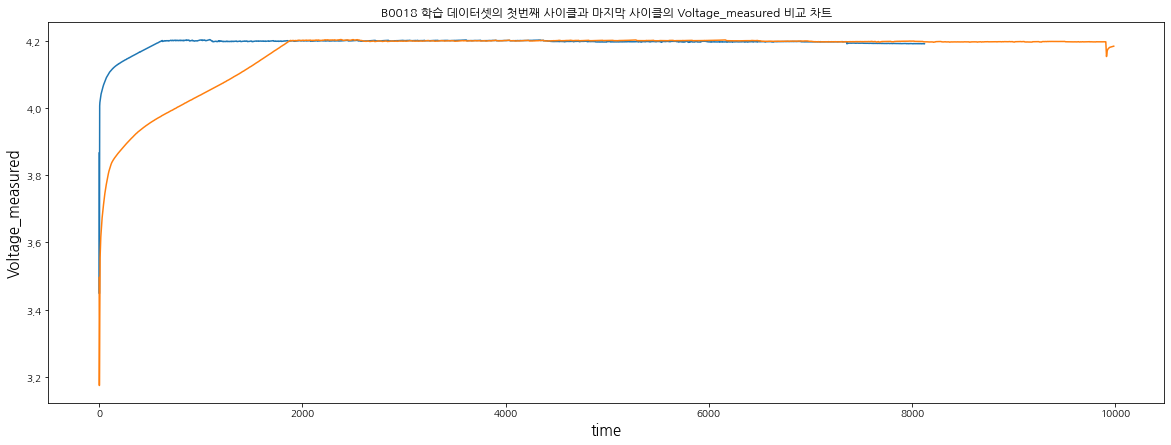

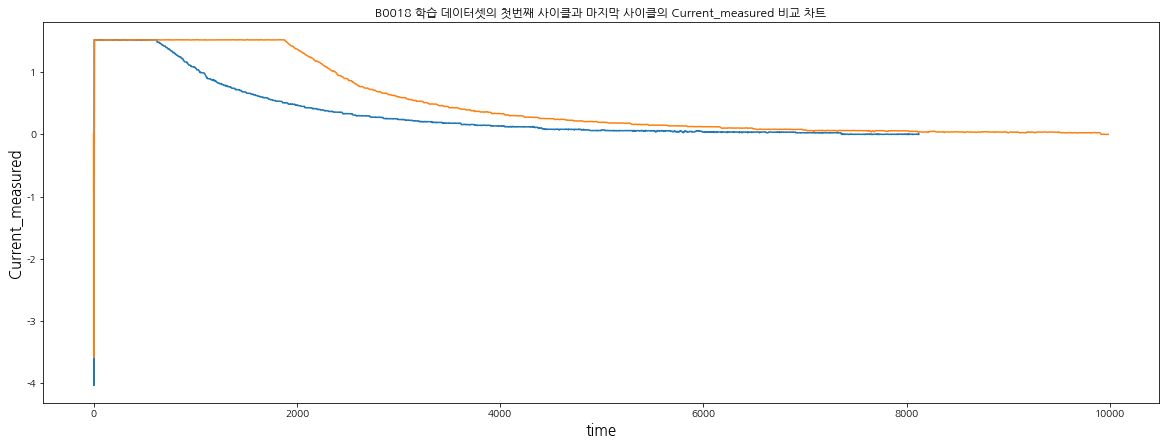

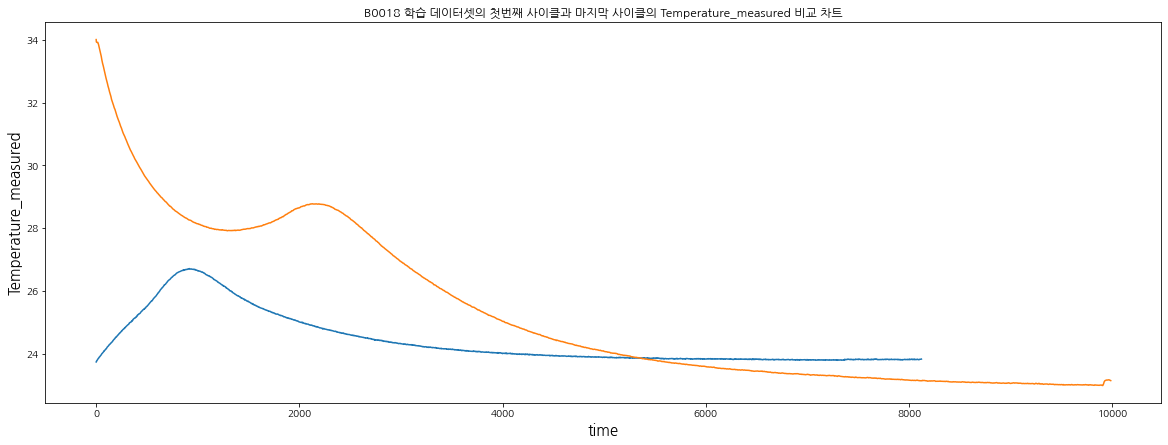

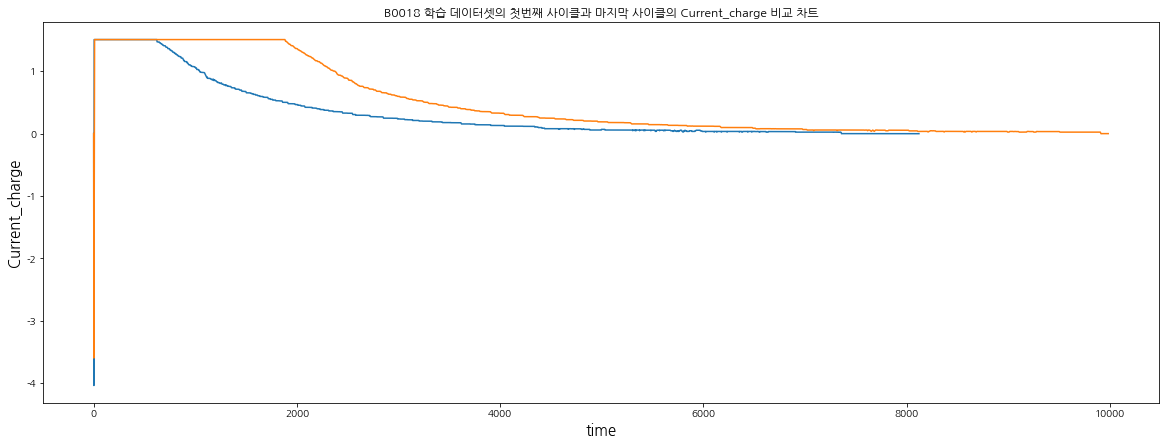

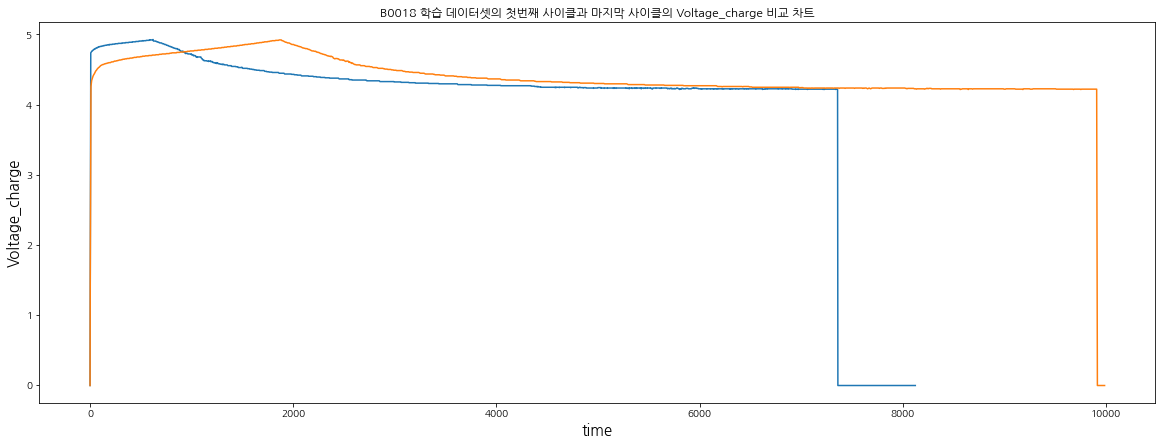

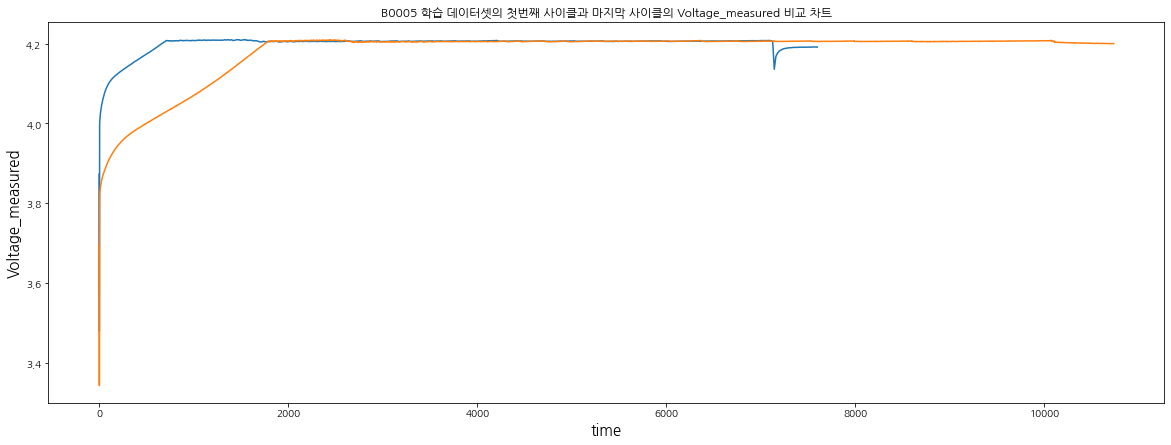

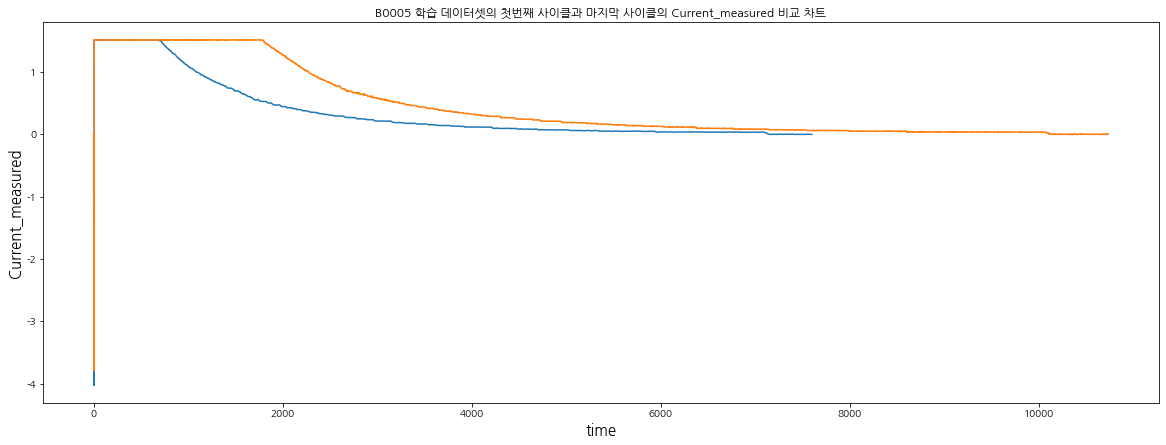

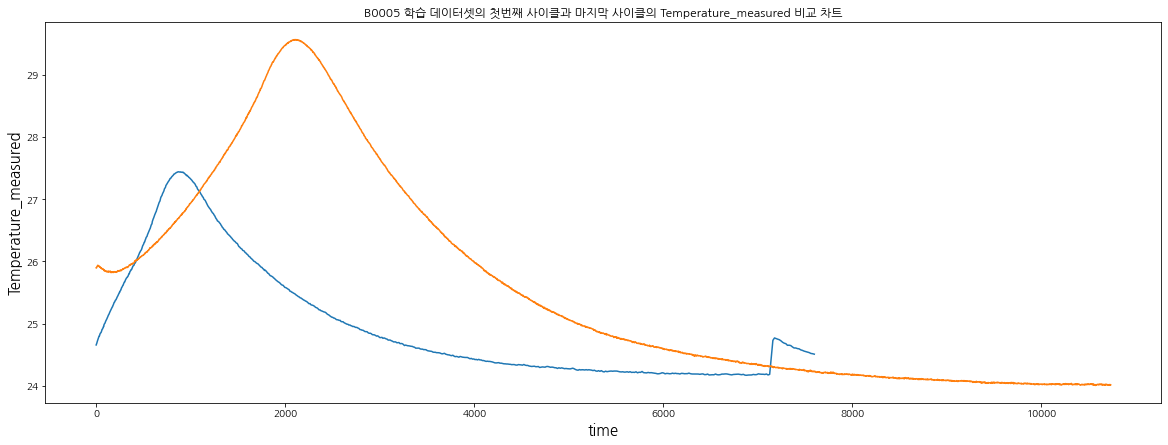

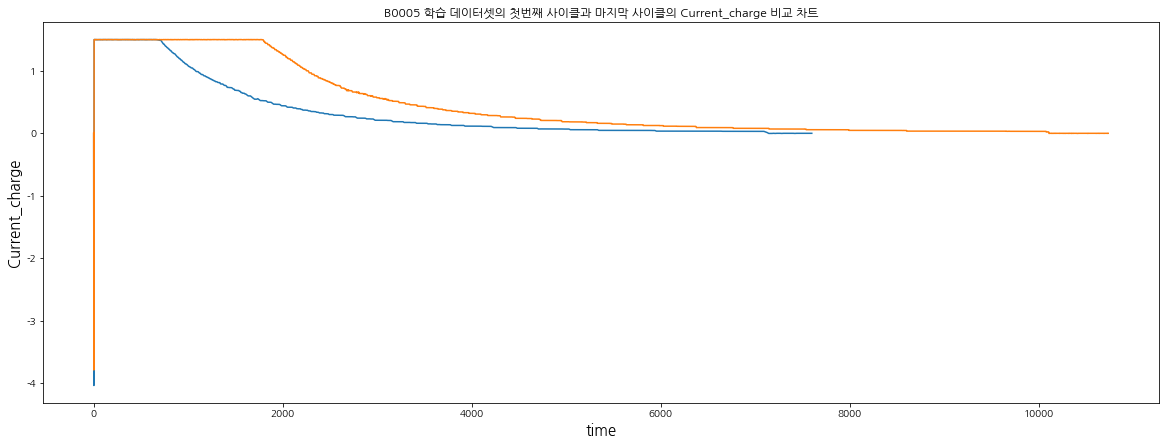

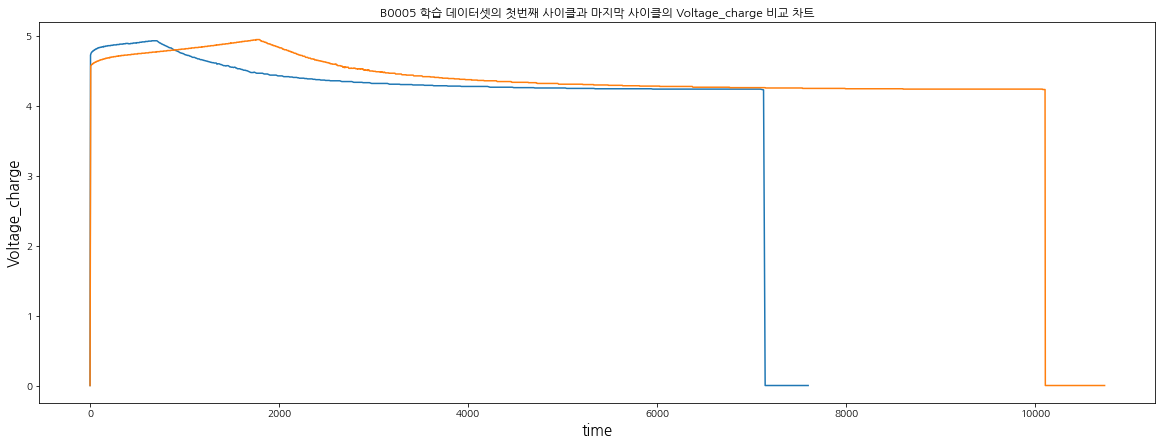

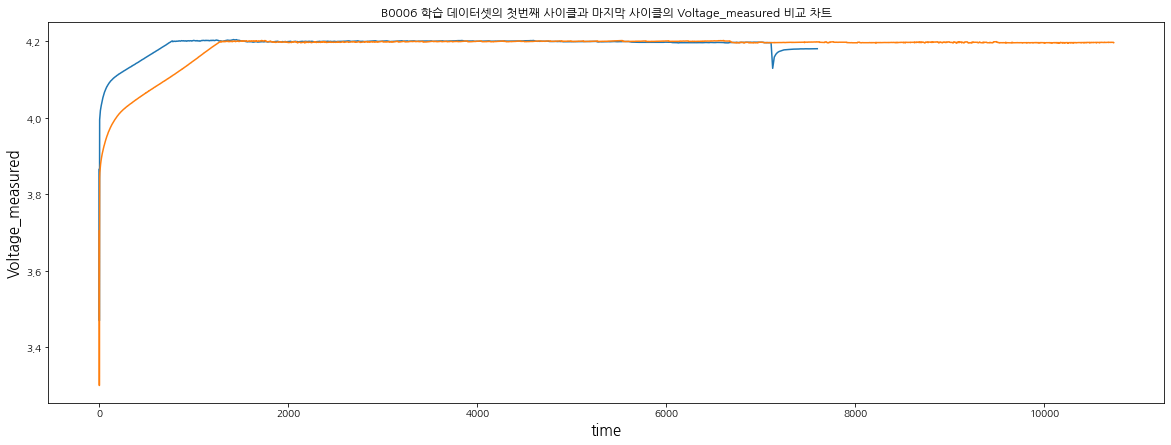

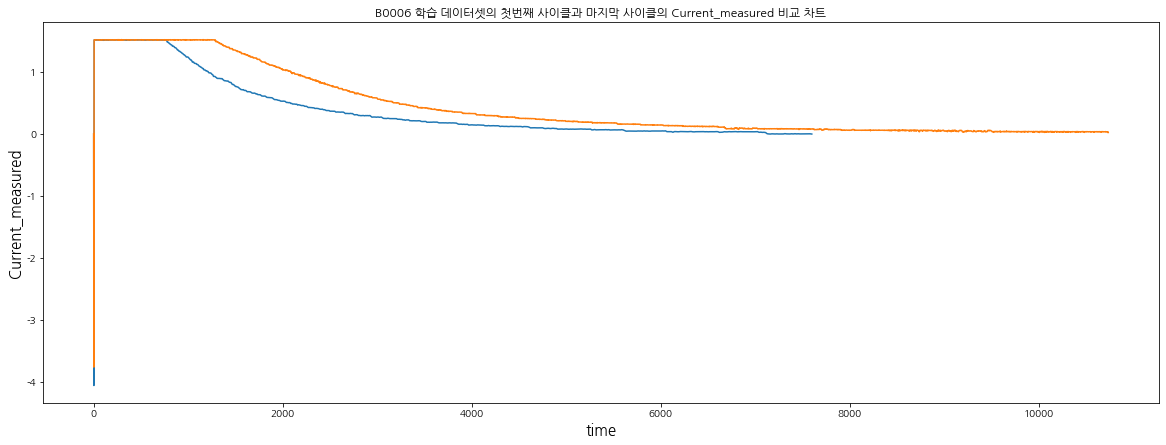

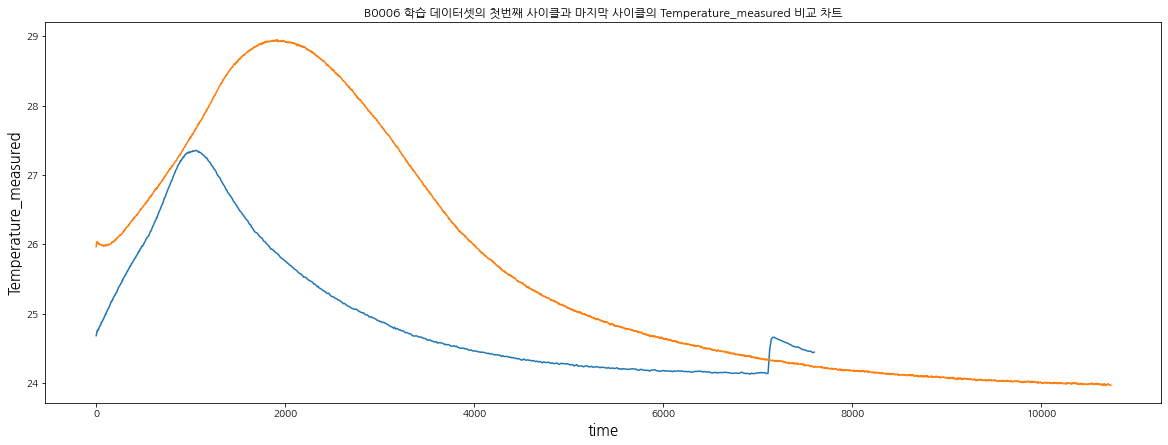

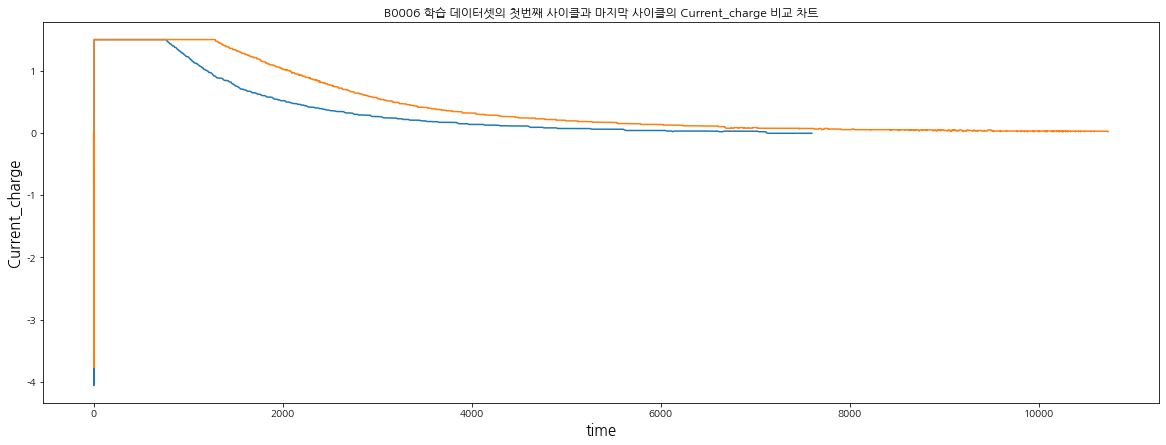

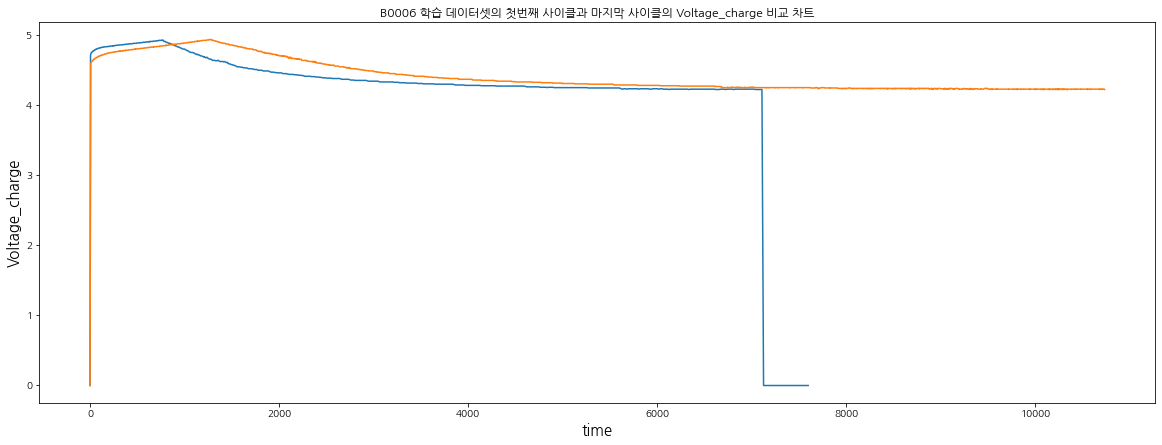

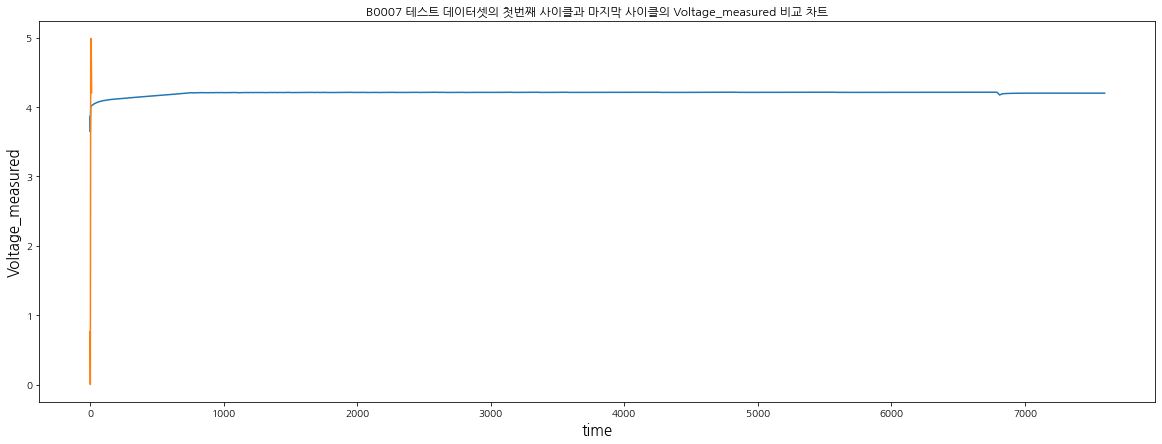

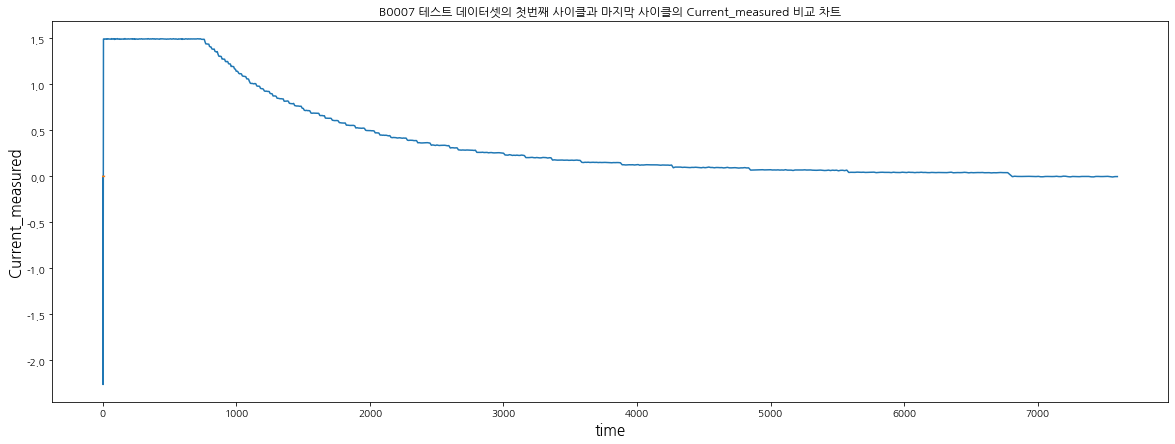

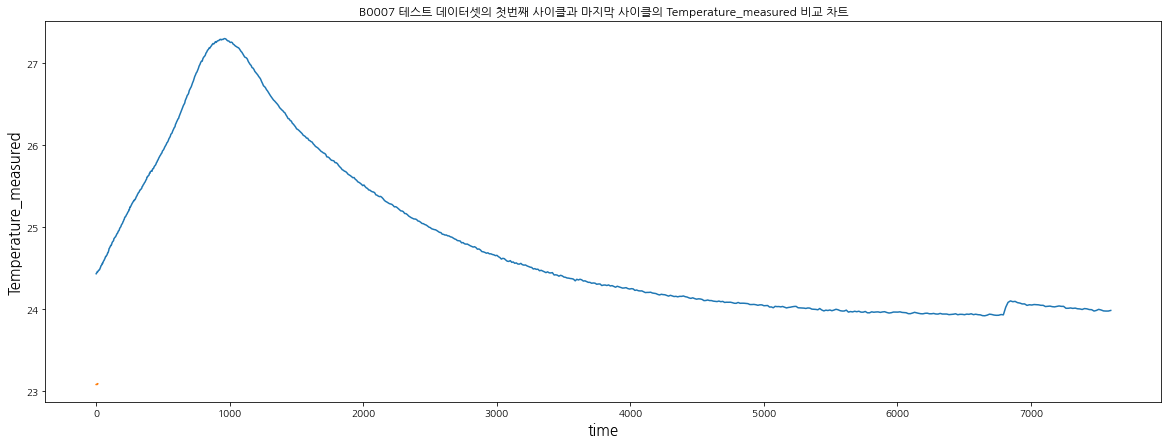

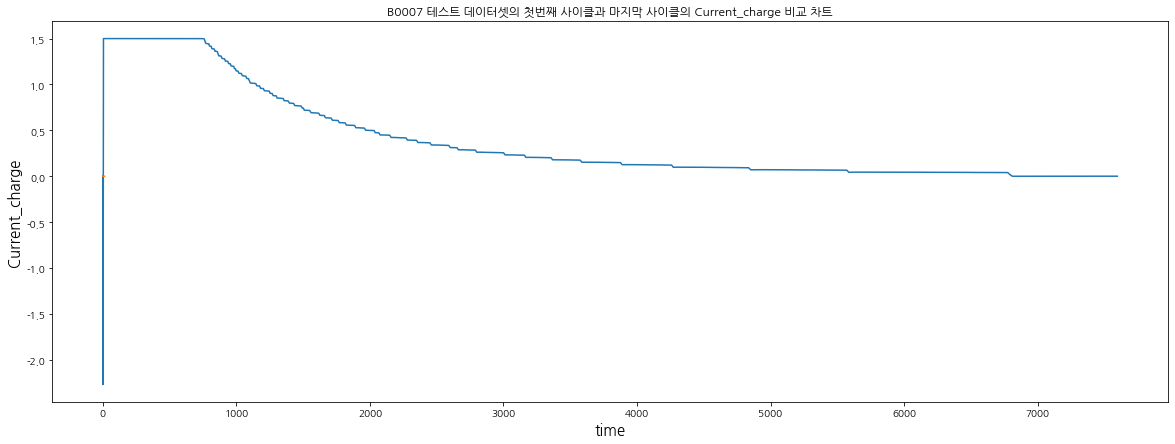

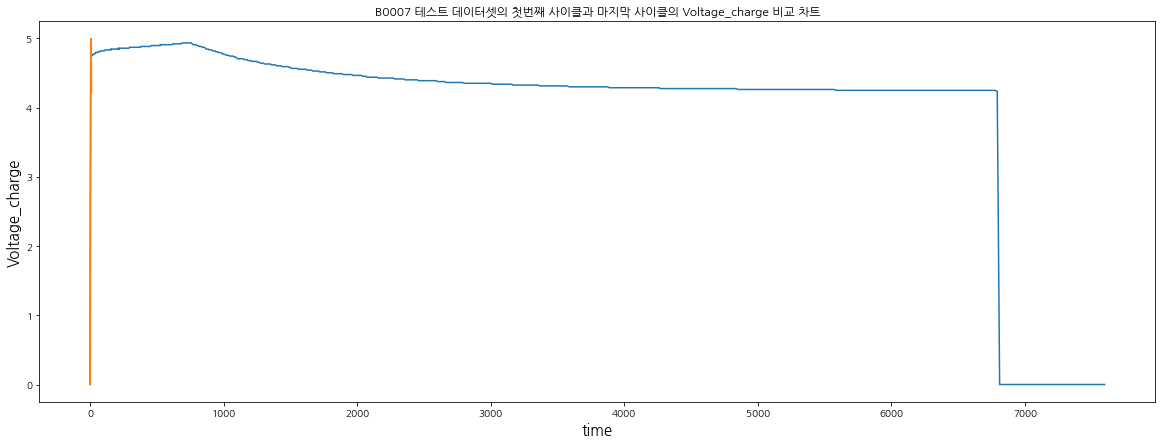

In [226]:
for i in range(len(trainset)):
    df1 = pd.DataFrame(train_data['charge'][i][0])
    df1 = df1.astype({ 'Time' : int })
    df1 = df1.set_index('Time',drop=True)
    
    df2 = pd.DataFrame(train_data['charge'][i][len(train_data['charge_time'][0])-1])
    df2 = df2.astype({ 'Time' : int })
    df2 = df2.set_index('Time',drop=True)

    for col in list(df1.columns):
        fig,ax = plt.subplots(nrows=1, figsize=(20, 7)) 
        ax.plot(df1.index, df1['%s'%col]) 
        ax.plot(df2.index, df2['%s'%col]) 
        ax.set_xlabel("time", fontsize = 15)
        ax.set_ylabel('%s'%col, fontsize = 15)
        ax.title.set_text("%s 학습 데이터셋의 첫번째 사이클과 마지막 사이클의 %s 비교 차트"%(trainset[i][0],col))

for i in range(len(testset)):
    df1 = pd.DataFrame(test_data['charge'][i][0])
    df1 = df1.astype({ 'Time' : int })
    df1 = df1.set_index('Time',drop=True)
    
    df2 = pd.DataFrame(test_data['charge'][i][len(test_data['charge_time'][0])-1])
    df2 = df2.astype({ 'Time' : int })
    df2 = df2.set_index('Time',drop=True)

    for col in list(df1.columns):
        fig,ax = plt.subplots(nrows=1, figsize=(20, 7)) 
        ax.plot(df1.index, df1['%s'%col]) 
        ax.plot(df2.index, df2['%s'%col]) 
        ax.set_xlabel("time", fontsize = 15)
        ax.set_ylabel('%s'%col, fontsize = 15)
        ax.title.set_text("%s 테스트 데이터셋의 첫번째 사이클과 마지막 사이클의 %s 비교 차트"%(testset[i][0],col))

### 1) 통계 분석
- 각 데이터셋별 충전 구간의 한개 사이클에 대한 데이터로 분석 시행

In [488]:
df = pd.DataFrame(train_data['charge'][0][0])
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      2816 non-null   float64
 1   Current_measured      2816 non-null   float64
 2   Temperature_measured  2816 non-null   float64
 3   Current_charge        2816 non-null   float64
 4   Voltage_charge        2816 non-null   float64
 5   Time                  2816 non-null   float64
dtypes: float64(6)
memory usage: 132.1 KB


,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
count,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000
mean,4.192373,0.359262,24.422292,0.356358,3.963833,4022.601732
std,0.024883,0.484517,0.820400,0.482018,1.318705,2374.243240
min,3.447651,-4.034445,23.735721,-4.036000,-0.007000,0.000000
25%,4.196085,0.037147,23.831061,0.035000,4.224000,1961.425500
50%,4.197277,0.131089,24.001031,0.130000,4.273000,4013.133000
75%,4.199445,0.481392,24.768957,0.478000,4.435000,6078.340000
max,4.202872,1.520641,26.713023,1.507000,4.926000,8122.844000


In [489]:
df.head(10)

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
0,3.865713,0.001014,23.735721,0.000,-0.007,0.000
1,3.447651,-4.034445,23.743956,-4.036,1.553,2.484
2,4.005559,1.517435,23.773723,1.507,4.721,5.109
3,4.015989,1.514558,23.777077,1.507,4.737,7.562
4,4.023230,1.517284,23.792710,1.507,4.743,10.062
5,4.028584,1.513730,23.801713,1.507,4.748,12.578
6,4.033122,1.514665,23.817946,1.507,4.753,15.062
7,4.037279,1.514694,23.823150,1.507,4.759,17.515
8,4.041157,1.514861,23.837332,1.507,4.764,19.969
9,4.044831,1.514295,23.853688,1.507,4.764,22.484


In [490]:
df['Current_charge'].value_counts()

1.507    246
0.000    210
0.035    175
0.024    148
0.033    110
        ... 
0.926      1
0.916      1
0.897      1
0.896      1
0.700      1
Name: Current_charge, Length: 285, dtype: int64

#### 1-2) 이상치 확인

[Text(1, 0, 'Voltage_measured'),
 Text(2, 0, 'Current_measured'),
 Text(3, 0, 'Temperature_measured'),
 Text(4, 0, 'Current_charge'),
 Text(5, 0, 'Voltage_charge')]

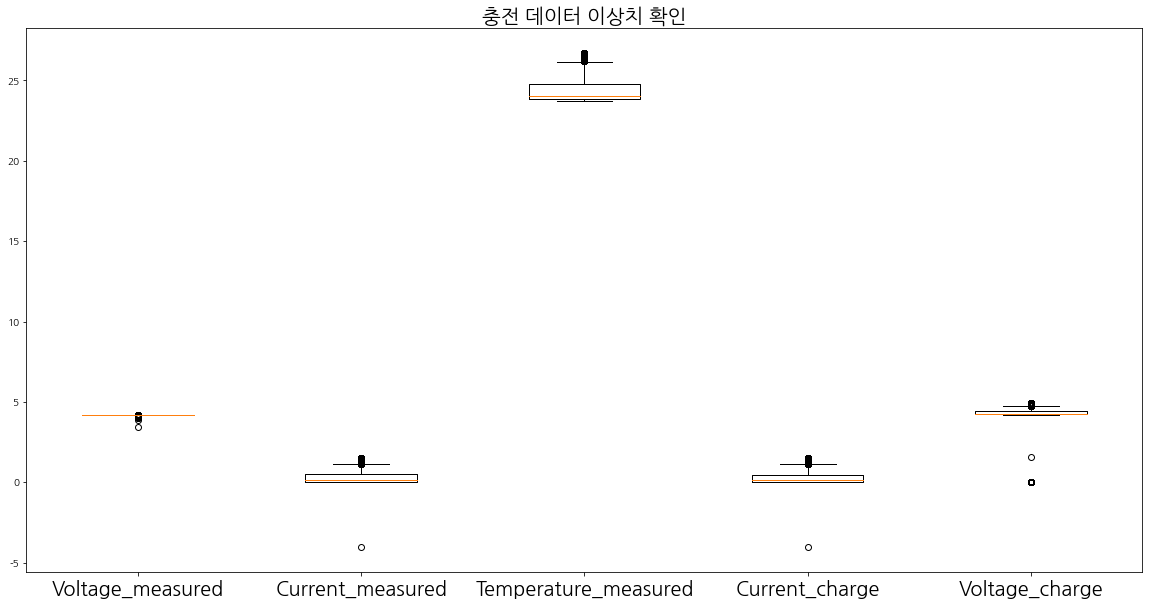

In [492]:
# 이상치 시각화

new_ch = df.set_index("Time", drop=True)

fig, ax = plt.subplots(1,1, figsize=(20,10))
x = np.arange(len(list(new_ch.columns)))
ax.boxplot(new_ch)
ax.set_title("충전 데이터 이상치 확인", fontsize=20)
ax.set_xticks([1,2,3,4,5])  # x
ax.set_xticklabels(new_ch.columns, fontsize=20)

In [603]:
# 각 컬럼별 이상치 숫자로 나타내기

def detect_outliers(df, n, features):
    features.pop(2)
    outlier_indices = []
    Outliers = {}
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
    
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.append(outlier_list_col)
#         print("Q1: %s"%Q1)
#         print("Q3: %s"%Q3)
#         print("IQR: %s"%IQR)
#         print("outlier_step: %s"%outlier_step)
    
    for i in range(len(features)):
         for col in features:
            Outliers[col] = df[col].loc[outlier_indices[i]].values
        
    return Outliers

In [604]:
Outliers = detect_outliers(new_ch, 1, list(new_ch.columns))

In [605]:
Outliers

{'Voltage_measured': array([3.86571283, 3.44765115, 4.03312247, 4.03727921, 4.04115743,
        4.04483064, 4.04803612, 4.05103238, 4.05367767, 4.05666242,
        4.0591768 , 4.06182441, 4.06402122, 4.06645251, 4.06880262,
        4.07122433, 4.07326693, 4.07540928, 4.07729704, 4.07920914,
        4.08116166, 4.08299971, 4.0848759 , 4.08668855, 4.08813594,
        4.08979754, 4.09136263, 4.09295855, 4.09433233, 4.09555759,
        4.09692582, 4.09828006, 4.09953414, 4.10056626, 4.10175594,
        4.10303481, 4.10406836, 4.10532934, 4.10617502, 4.10721973,
        4.10818197, 4.10894322, 4.10976167, 4.1108538 , 4.11176492,
        4.11245181, 4.11340763, 4.11404298, 4.11487762, 4.11578376,
        4.116558  , 4.11693479, 4.11806036, 4.11869617, 4.11925164,
        4.12000714, 4.12055109, 4.12126877, 4.1220758 , 4.12260729,
        4.12330535, 4.12393799, 4.12434743, 4.12507866, 4.12550391,
        4.12589034, 4.12656492, 4.12746609, 4.12771728, 4.12850617,
        4.12886529, 4.129241

# 방전 구간 분석

- 방전 구간 주기: 10초

In [328]:
capacity = {}
for j in range(len(trainset)):
    train_cap = []
    test_cap =[]
    for i in range(len(new_train[j])-1):
        train_cap.append(float(train_data['discharge'][j][i]['Capacity']))
    capacity['train%s'%j] = train_cap
for j in range(len(testset)):
    for i in range(len(new_test[j])-1):
        test_cap.append(float(test_data['discharge'][j][i]['Capacity']))
    capacity['test%s'%j] = test_cap

In [331]:
print("< 방전 구간 >\n")

print("사이클별 B0018 학습 데이터 정격용량: \n%s\n"%(capacity['train0']))
print("사이클별 B0005 학습 데이터 정격용량: \n%s\n"%(capacity['train1']))
print("사이클별 B0006 학습 데이터의 정격용량: \n%s\n"%(capacity['train2']))
print("사이클별 B0007 테스트 데이터의 정격용량: \n%s\n"%(capacity['test0']))

< 방전 구간 >

사이클별 B0018 학습 데이터 정격용량: 
[1.8550045207910817, 1.8431955317089987, 1.8396018424355423, 1.8306736044962053, 1.8327002069419656, 1.8285288846046388, 1.8212011895697924, 1.8151700106433282, 1.8042980520967649, 1.8231002302844226, 1.8121253520255494, 1.8046916382117766, 1.790844349786295, 1.783470722841926, 1.7809386125310702, 1.771209039672698, 1.7686303996707076, 1.7536304801917124, 1.7462197416415093, 1.7376647337053737, 1.7315166735475835, 1.7085949894470602, 1.711469957068211, 1.7075021373272627, 1.7492382064360228, 1.7327697147429955, 1.7222313328292376, 1.711846298984729, 1.699267835126687, 1.6940366439243106, 1.6819027078768087, 1.6769770618433686, 1.6655229306478936, 1.6571924575832084, 1.6482241555294048, 1.6387701497987262, 1.6276486907262062, 1.62215370227252, 1.6140066510467586, 1.6760516154424623, 1.649300642552199, 1.63238299185809, 1.6164159719025777, 1.6109028378249377, 1.5954638693695657, 1.726707440085764, 1.7165673917429753, 1.6958235570934848, 1.6777783190792

In [333]:
new_train = train_data['discharge'].copy()
new_test = test_data['discharge'].copy()

In [334]:
for j in range(len(trainset)):
    for i in range(len(new_train[j])-1):
        new_train[j][i].pop('Capacity',None)

for j in range(len(testset)):
    for i in range(len(new_test[j])-1):
        new_test[j][i].pop('Capacity',None)

In [335]:
dataset = {}
for j in range(len(trainset)):
    df_size = []
    for i in range(len(new_train[j])-1):
        df = pd.DataFrame(new_train[j][i])
        df_size.append(df.shape[0])
    dataset["train%s"%j] = df_size
    
for j in range(len(testset)):
    df_size = []
    for i in range(len(new_test[j])-1):
        df = pd.DataFrame(new_test[j][i])
        df_size.append(df.shape[0])
    dataset["test%s"%j] = df_size

In [336]:
print("< 방전 구간 >\n")

print("사이클별 B0018 학습 데이터 크기: %s\n"%(dataset['train0']))
print("사이클별 B0005 학습 데이터 크기: %s\n"%(dataset['train1']))
print("사이클별 B0006 학습 데이터의 크기: %s\n"%(dataset['train2']))
print("사이클별 B0007 테스트 데이터의 크기: %s\n"%(dataset['test0']))

< 방전 구간 >

사이클별 B0018 학습 데이터 크기: [366, 362, 358, 355, 354, 351, 348, 345, 342, 343, 340, 337, 334, 331, 330, 327, 325, 323, 320, 317, 315, 314, 311, 309, 312, 310, 308, 306, 304, 302, 300, 298, 296, 295, 292, 281, 289, 287, 286, 288, 286, 283, 281, 279, 277, 301, 298, 295, 292, 290, 289, 286, 284, 281, 280, 279, 279, 276, 273, 271, 269, 267, 265, 263, 261, 259, 257, 256, 253, 252, 255, 253, 251, 249, 247, 245, 243, 242, 241, 239, 238, 236, 235, 234, 233, 237, 234, 232, 230, 229, 230, 229, 227, 226, 224, 223, 222, 221, 219, 216, 218, 217, 216, 215, 214, 223, 222, 221, 208, 217, 205, 215, 214, 213, 212, 211, 209, 208, 207, 201, 212, 211, 209, 208, 206, 206, 204, 204, 204, 202, 201]

사이클별 B0005 학습 데이터 크기: [197, 196, 195, 194, 194, 195, 195, 191, 190, 190, 189, 187, 186, 186, 185, 184, 183, 182, 182, 192, 190, 189, 187, 188, 184, 184, 183, 183, 183, 182, 371, 365, 363, 362, 360, 360, 359, 357, 356, 355, 355, 354, 179, 354, 352, 350, 349, 356, 356, 353, 351, 350, 349, 349, 348, 347, 346, 34

In [339]:
print("< 방전 구간 >\n")

print("B0018 학습 데이터의 충전 사이클 수: %d"%len(new_train[0]))
print("B0005 학습 데이터의 충전 사이클 수: %d"%len(new_train[1]))
print("B0006 학습 데이터의 충전 사이클 수: %d"%len(new_train[2]))
print("B0007 테스트 데이터의 충전 사이클 수: %d"%len(new_test[0]))

< 방전 구간 >

B0018 학습 데이터의 충전 사이클 수: 132
B0005 학습 데이터의 충전 사이클 수: 168
B0006 학습 데이터의 충전 사이클 수: 168
B0007 테스트 데이터의 충전 사이클 수: 168


In [340]:
time_1 = list(map(int,train_data['discharge_time'][0][0]))
time_e1 = list(map(int,train_data['discharge_time'][0][len(train_data['discharge_time'][0])-1]))

time_2 = list(map(int,train_data['discharge_time'][1][0]))
time_e2 = list(map(int,train_data['discharge_time'][1][len(train_data['discharge_time'][1])-1]))

time_3 = list(map(int,train_data['discharge_time'][2][0]))
time_e3 = list(map(int,train_data['discharge_time'][2][len(train_data['discharge_time'][2])-1]))

time_4 = list(map(int,test_data['discharge_time'][0][0]))
time_e4 = list(map(int,test_data['discharge_time'][0][len(test_data['discharge_time'][0])-1]))

print("B0018 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_1[0],time_1[1],time_1[2],time_1[3],time_1[4],time_1[5]))
print("B0018 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e1[0],time_e1[1],time_e1[2],time_e1[3],time_e1[4],time_e1[5]))

print("B0005 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_2[0],time_2[1],time_2[2],time_2[3],time_2[4],time_2[5]))
print("B0005 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e2[0],time_e2[1],time_e2[2],time_e2[3],time_e2[4],time_e2[5]))

print("B0006 학습 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_3[0],time_3[1],time_3[2],time_3[3],time_3[4],time_3[5]))
print("B0006 학습 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s\n"%(time_e3[0],time_e3[1],time_e3[2],time_e3[3],time_e3[4],time_e3[5]))

print("B0007 테스트 데이터의 첫번째 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_4[0],time_4[1],time_4[2],time_4[3],time_4[4],time_4[5]))
print("B0007 테스트 데이터의 마지막 사이클 충전 시작 시간: %s.%s.%s %s-%s-%s"%(time_e4[0],time_e4[1],time_e4[2],time_e4[3],time_e4[4],time_e4[5]))


B0018 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.7.7 15-15-28
B0018 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.8.20 8-37-19

B0005 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 15-25-41
B0005 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.5.27 20-45-42

B0006 학습 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 15-25-41
B0006 학습 데이터의 마지막 사이클 충전 시작 시간: 2008.5.27 20-45-42

B0007 테스트 데이터의 첫번째 사이클 충전 시작 시간: 2008.4.2 15-25-41
B0007 테스트 데이터의 마지막 사이클 충전 시작 시간: 2008.5.27 20-45-42


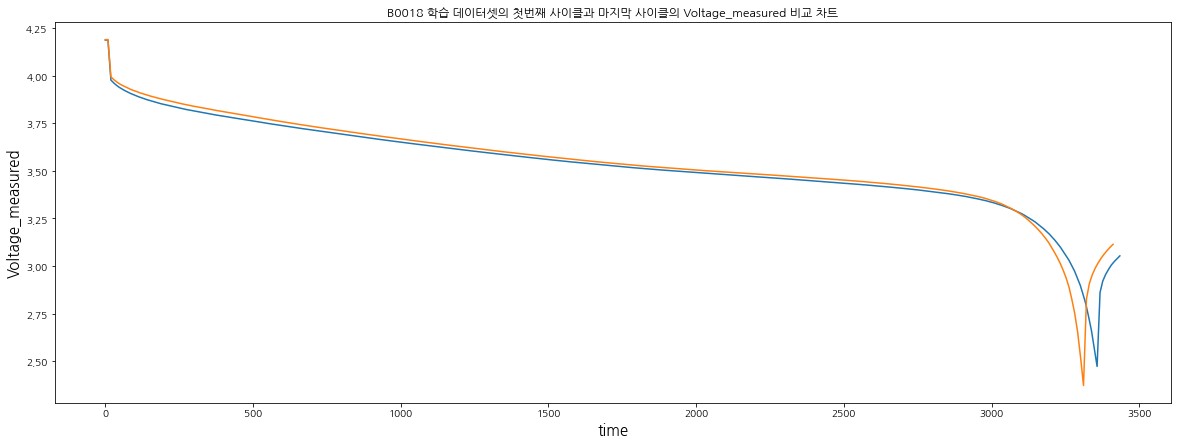

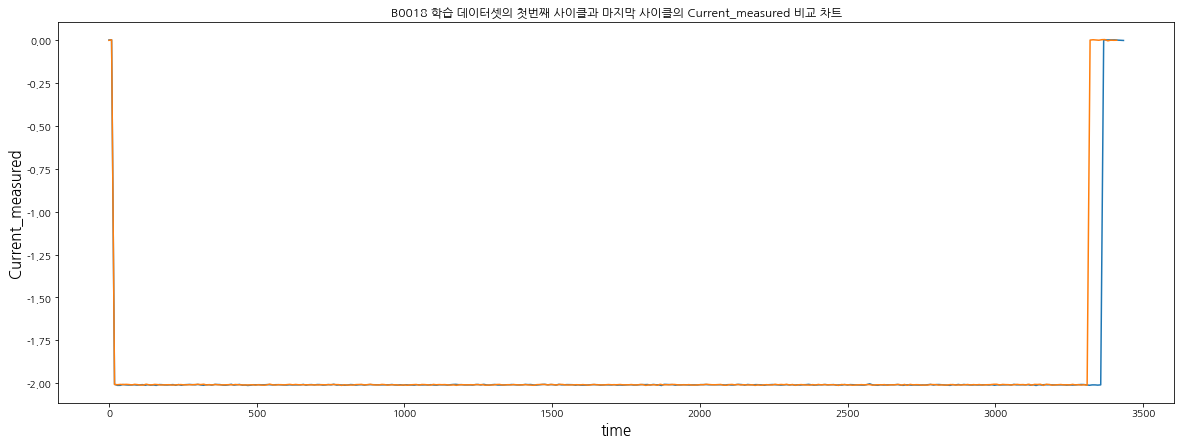

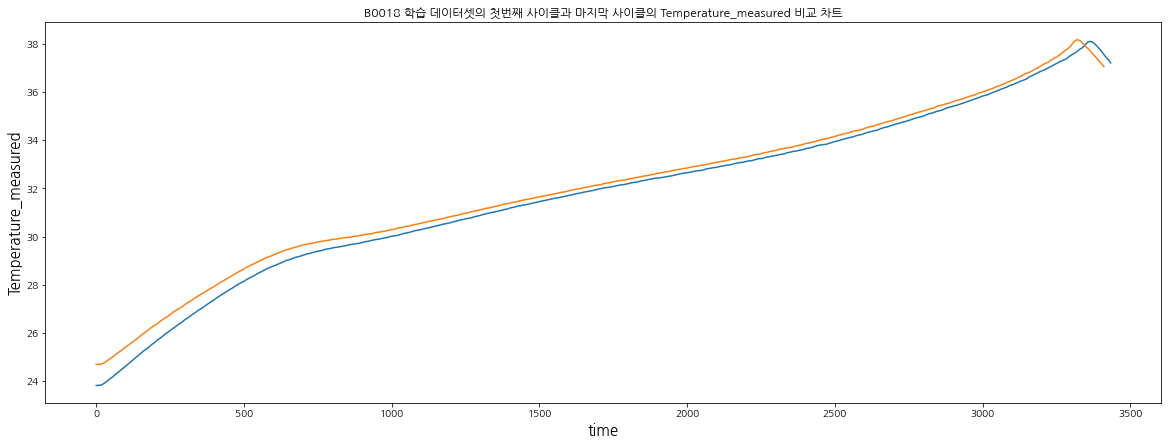

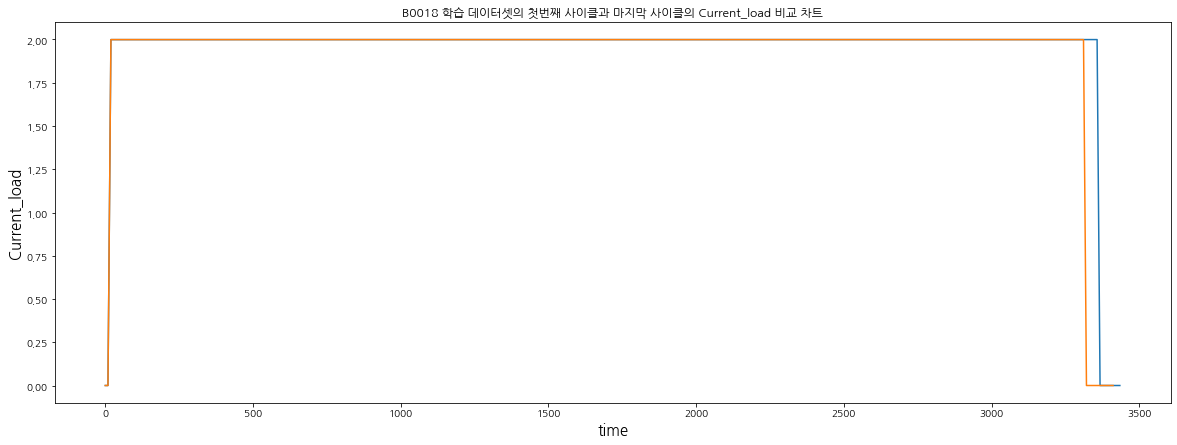

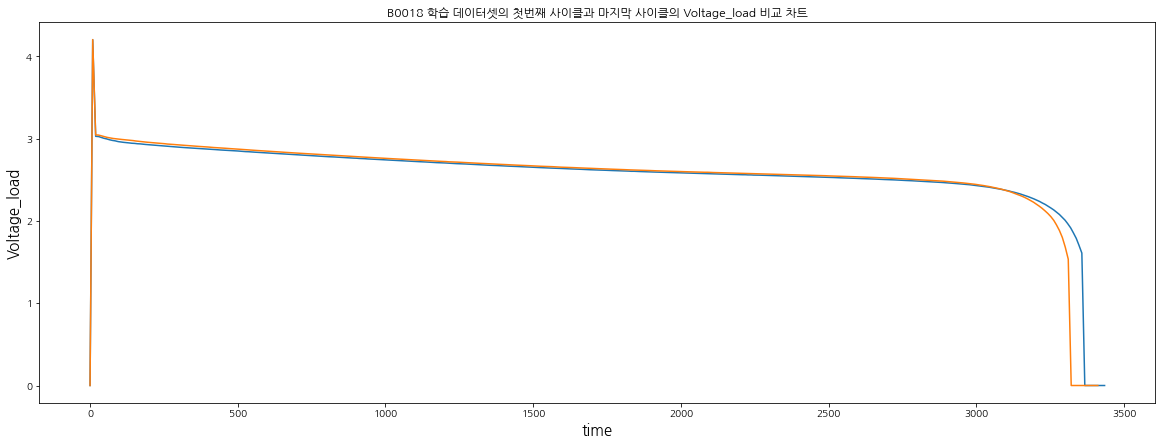

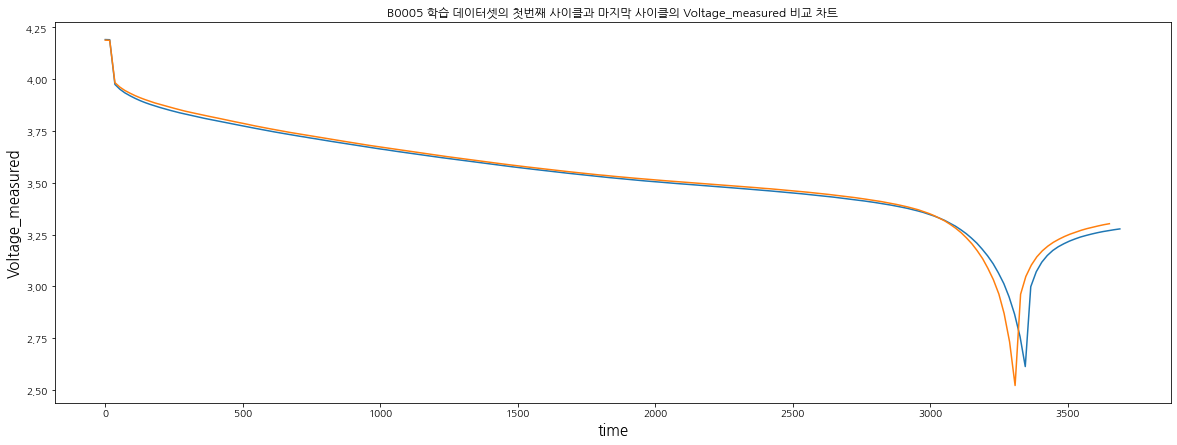

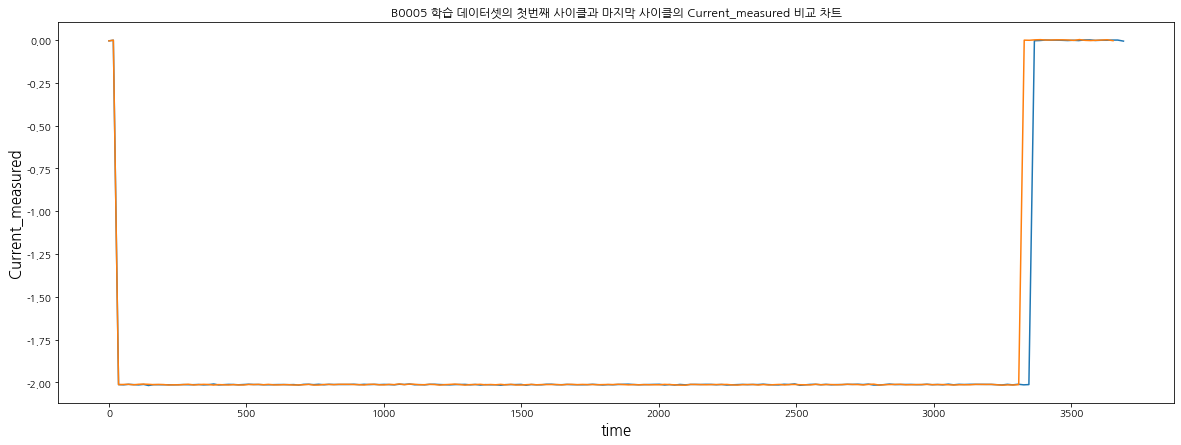

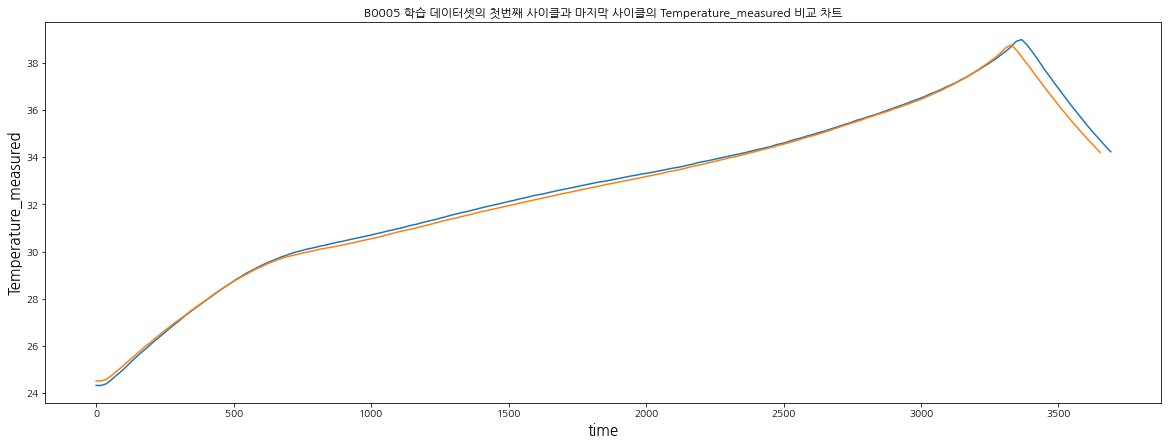

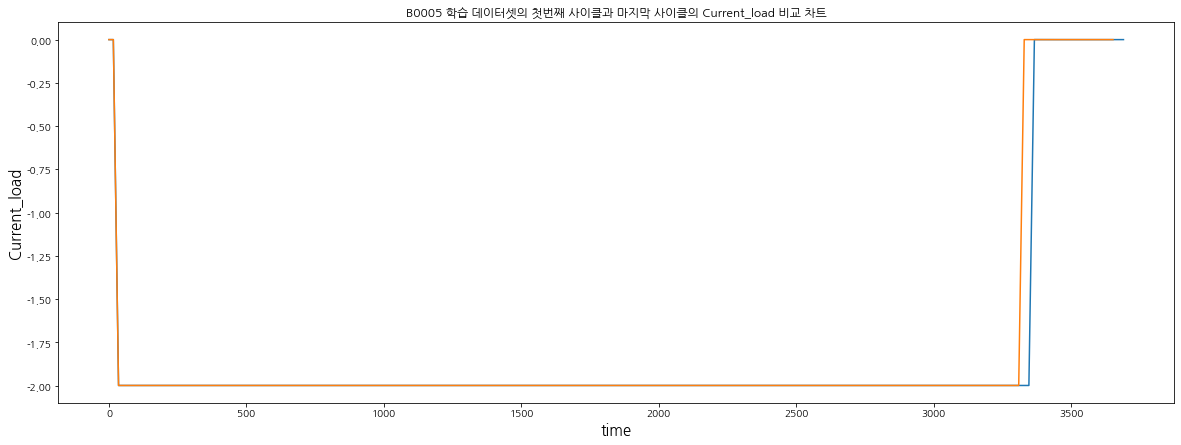

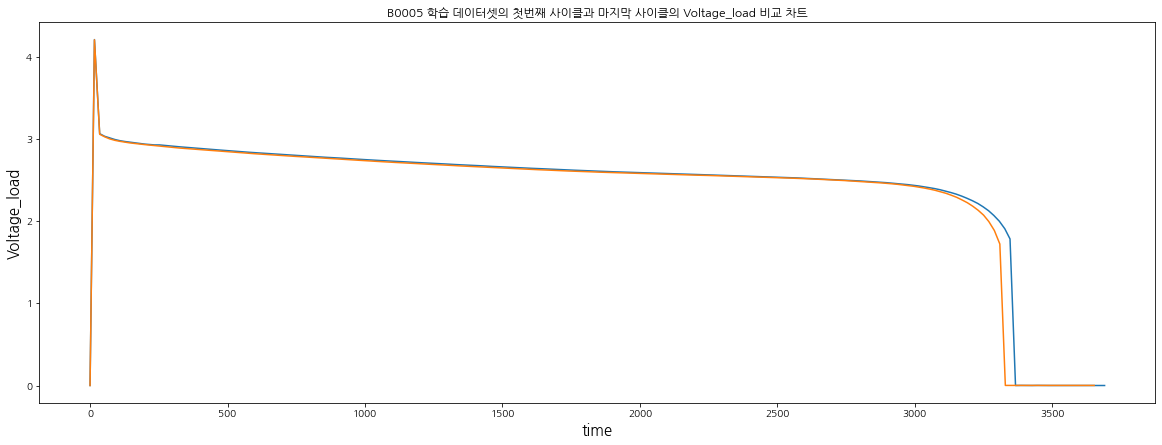

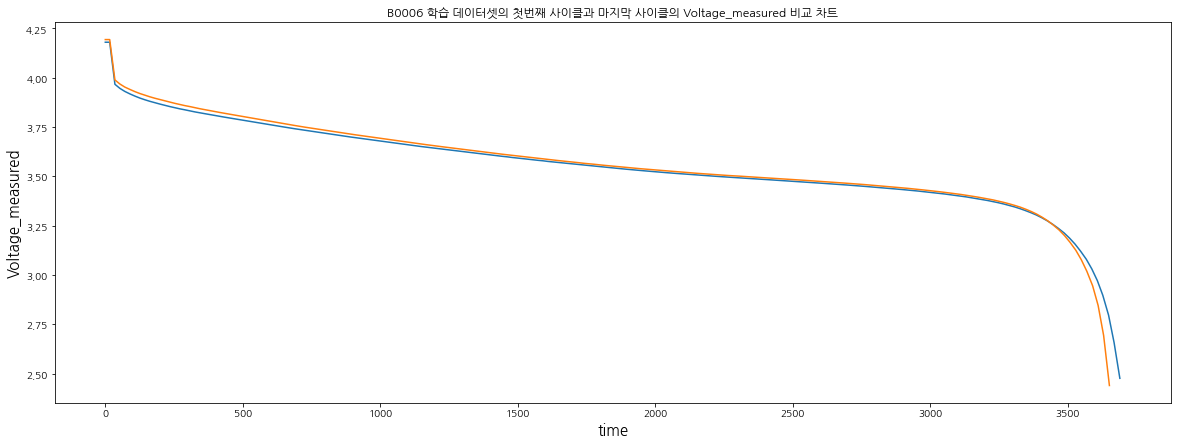

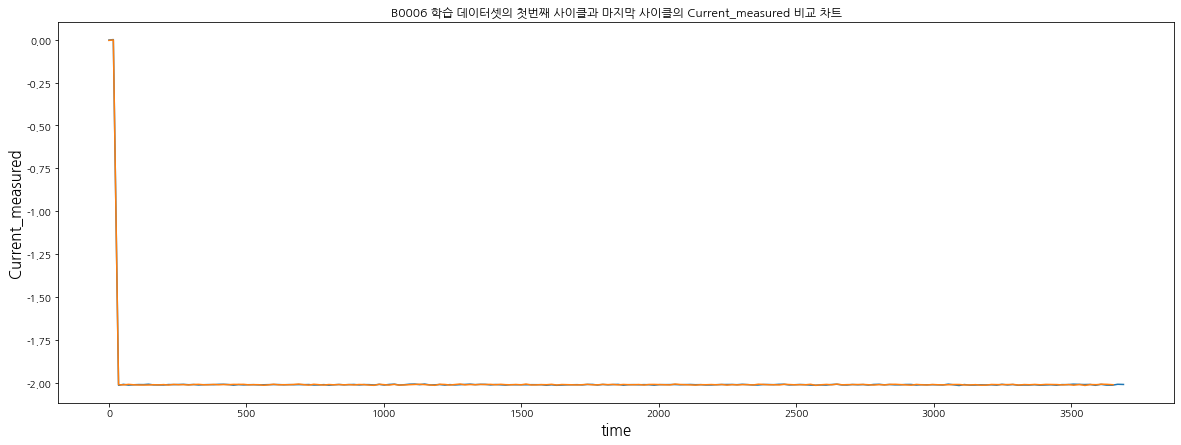

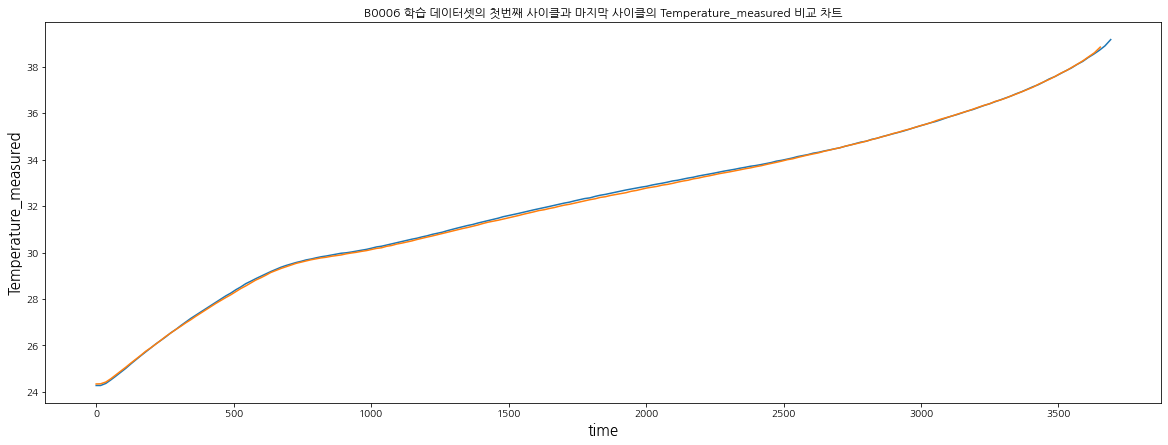

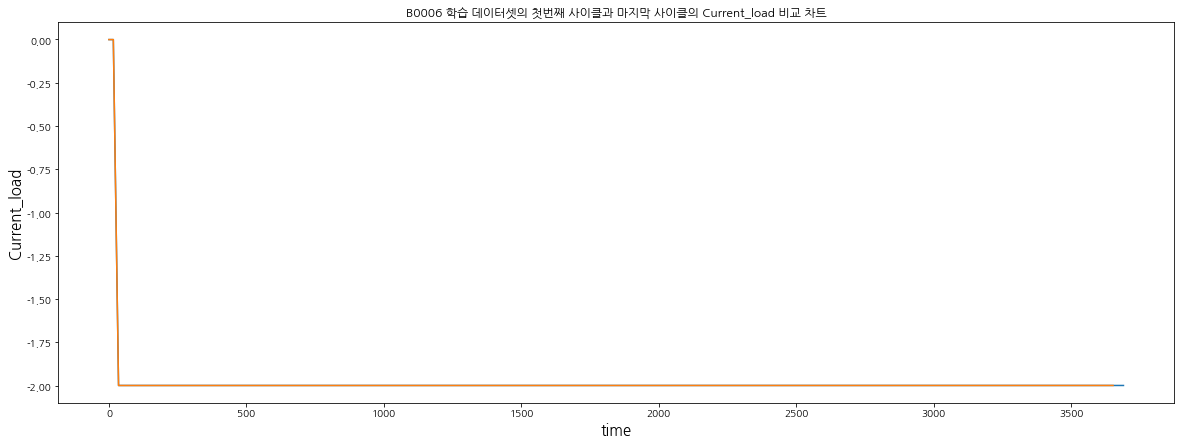

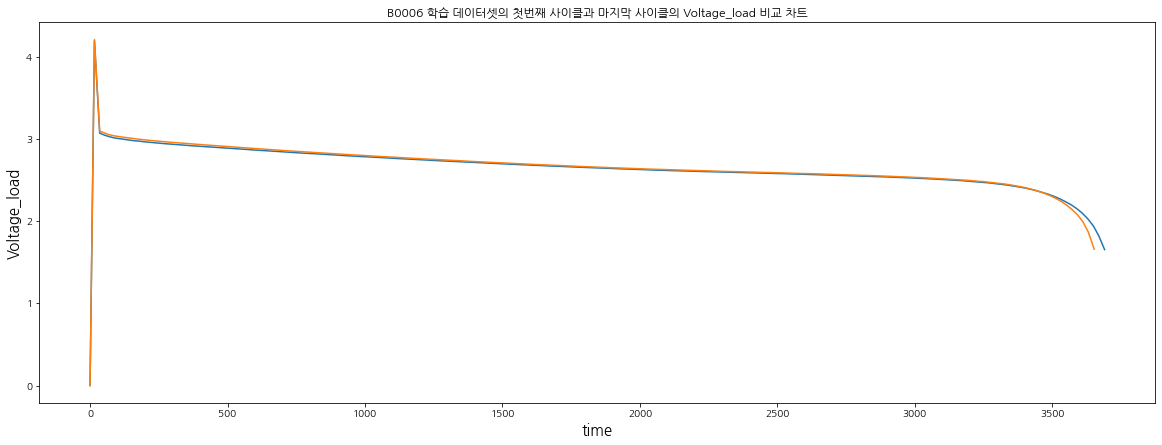

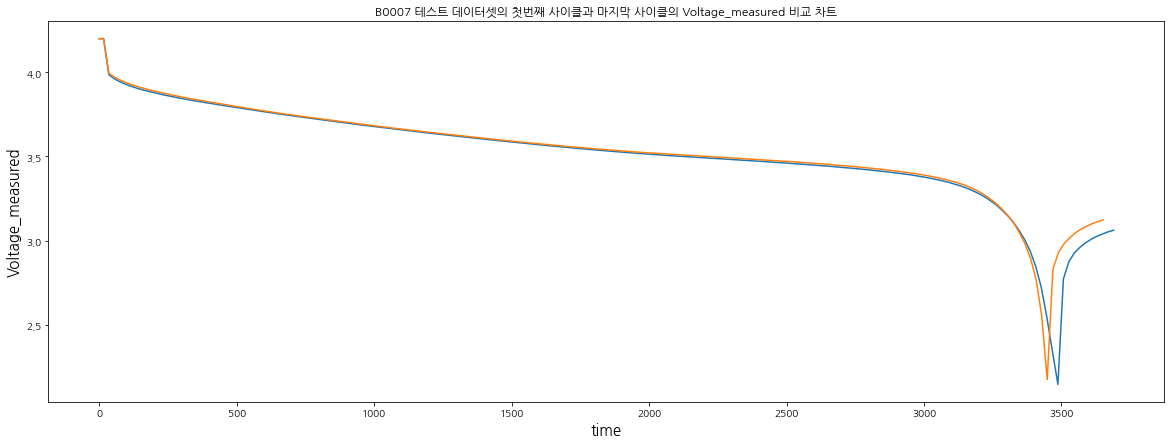

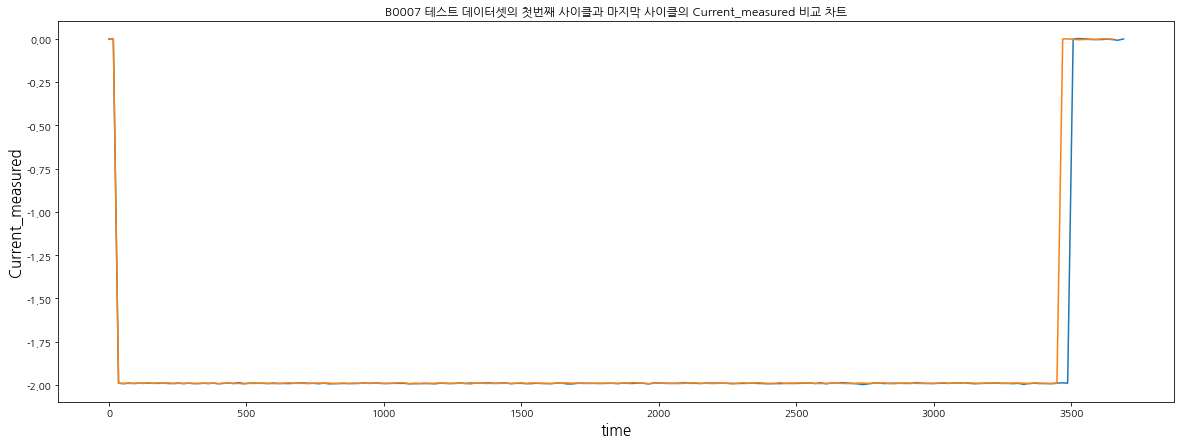

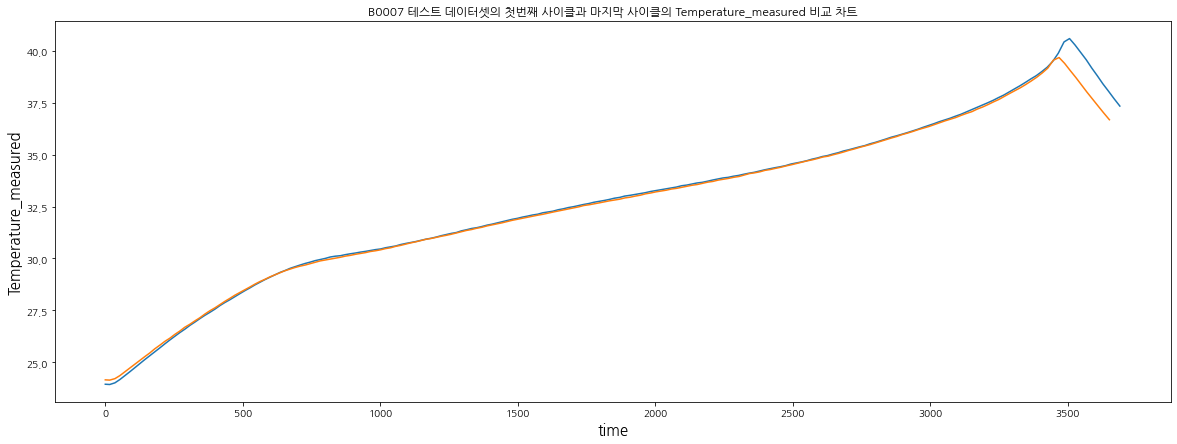

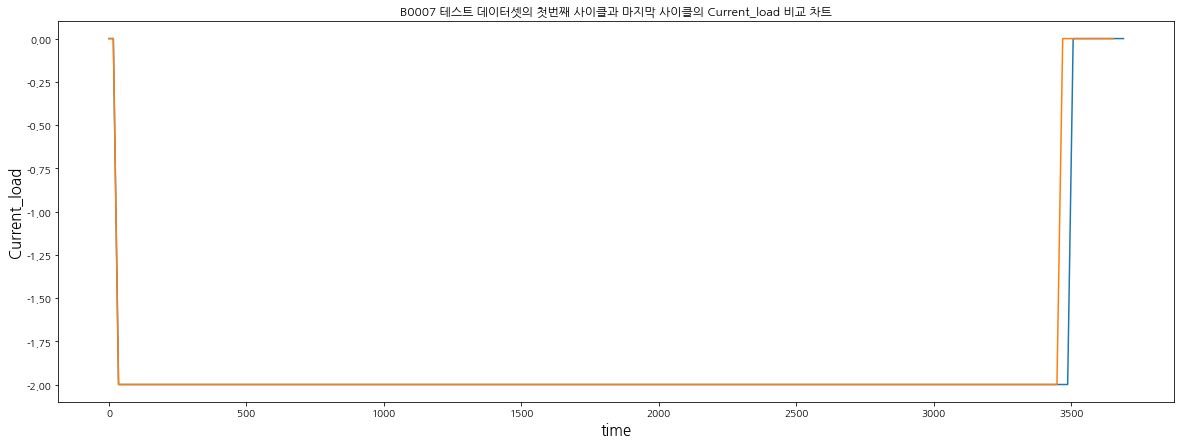

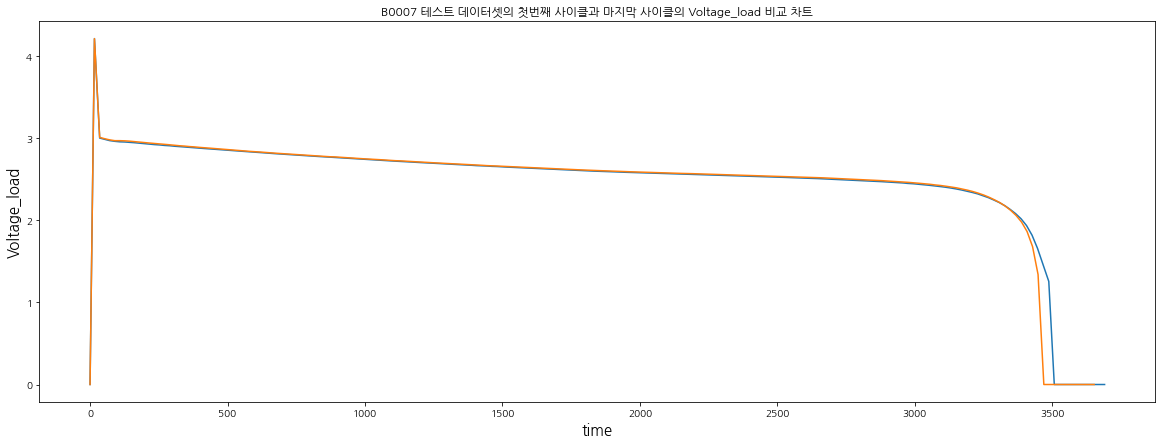

In [345]:
for i in range(len(trainset)):
    df1 = pd.DataFrame(new_train[i][0])
    df1 = df1.astype({ 'Time' : int })
    df1 = df1.set_index('Time',drop=True)
    
    df2 = pd.DataFrame(new_train[i][len(new_train[i][0])-1])
    df2 = df2.astype({ 'Time' : int })
    df2 = df2.set_index('Time',drop=True)

    for col in list(df1.columns):
        fig,ax = plt.subplots(nrows=1, figsize=(20, 7)) 
        ax.plot(df1.index, df1['%s'%col]) 
        ax.plot(df2.index, df2['%s'%col]) 
        ax.set_xlabel("time", fontsize = 15)
        ax.set_ylabel('%s'%col, fontsize = 15)
        ax.title.set_text("%s 학습 데이터셋의 첫번째 사이클과 마지막 사이클의 %s 비교 차트"%(trainset[i][0],col))

for i in range(len(testset)):
    df1 = pd.DataFrame(new_test[i][0])
    df1 = df1.astype({ 'Time' : int })
    df1 = df1.set_index('Time',drop=True)
    
    df2 = pd.DataFrame(new_test[i][len(new_test[i][0])-1])
    df2 = df2.astype({ 'Time' : int })
    df2 = df2.set_index('Time',drop=True)

    for col in list(df1.columns):
        fig,ax = plt.subplots(nrows=1, figsize=(20, 7)) 
        ax.plot(df1.index, df1['%s'%col]) 
        ax.plot(df2.index, df2['%s'%col]) 
        ax.set_xlabel("time", fontsize = 15)
        ax.set_ylabel('%s'%col, fontsize = 15)
        ax.title.set_text("%s 테스트 데이터셋의 첫번째 사이클과 마지막 사이클의 %s 비교 차트"%(testset[i][0],col))

### 1) 통계 분석
- 각 데이터셋별 충전 구간의 한개 사이클에 대한 데이터로 분석 시행

#### 1-1) 기본 통계

In [608]:
df_dis = pd.DataFrame(new_train[0][0])  # 예시
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      2816 non-null   float64
 1   Current_measured      2816 non-null   float64
 2   Temperature_measured  2816 non-null   float64
 3   Current_charge        2816 non-null   float64
 4   Voltage_charge        2816 non-null   float64
 5   Time                  2816 non-null   float64
dtypes: float64(6)
memory usage: 132.1 KB


,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
count,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000
mean,4.192373,0.359262,24.422292,0.356358,3.963833,4022.601732
std,0.024883,0.484517,0.820400,0.482018,1.318705,2374.243240
min,3.447651,-4.034445,23.735721,-4.036000,-0.007000,0.000000
25%,4.196085,0.037147,23.831061,0.035000,4.224000,1961.425500
50%,4.197277,0.131089,24.001031,0.130000,4.273000,4013.133000
75%,4.199445,0.481392,24.768957,0.478000,4.435000,6078.340000
max,4.202872,1.520641,26.713023,1.507000,4.926000,8122.844000


In [609]:
df_dis.head(10)

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.188109,0.000131,23.819520,0.0006,0.000,0.000
1,4.188196,0.001459,23.828807,0.0006,4.203,9.422
2,3.977432,-2.005672,23.844944,1.9988,3.029,19.578
3,3.961974,-2.012206,23.925577,1.9988,3.026,29.016
4,3.949835,-2.012005,24.010628,1.9988,3.015,38.485
5,3.939550,-2.007285,24.103192,1.9988,3.005,47.906
6,3.930454,-2.009340,24.191621,1.9988,2.997,57.328
7,3.922180,-2.010267,24.294344,1.9990,2.987,66.750
8,3.914649,-2.010024,24.382616,1.9988,2.979,76.156
9,3.907585,-2.008671,24.476315,1.9988,2.974,85.594


In [610]:
df_dis['Current_load'].value_counts()

1.9990    269
1.9988     87
0.0006     10
Name: Current_load, dtype: int64

#### 1-2) 이상치 확인

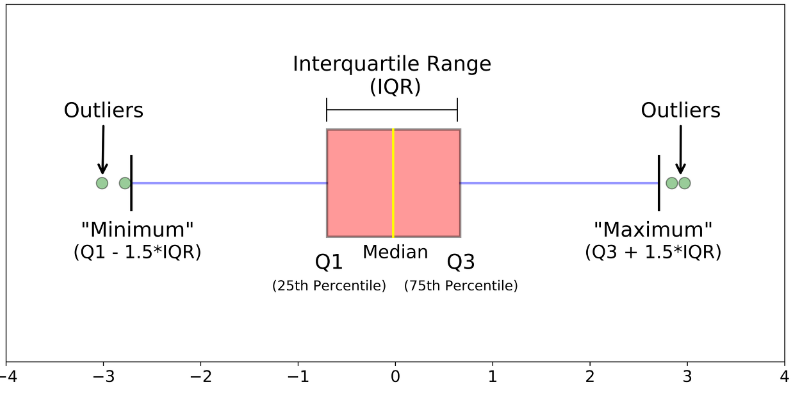

[Text(1, 0, 'Voltage_measured'),
 Text(2, 0, 'Current_measured'),
 Text(3, 0, 'Temperature_measured'),
 Text(4, 0, 'Current_load'),
 Text(5, 0, 'Voltage_load')]

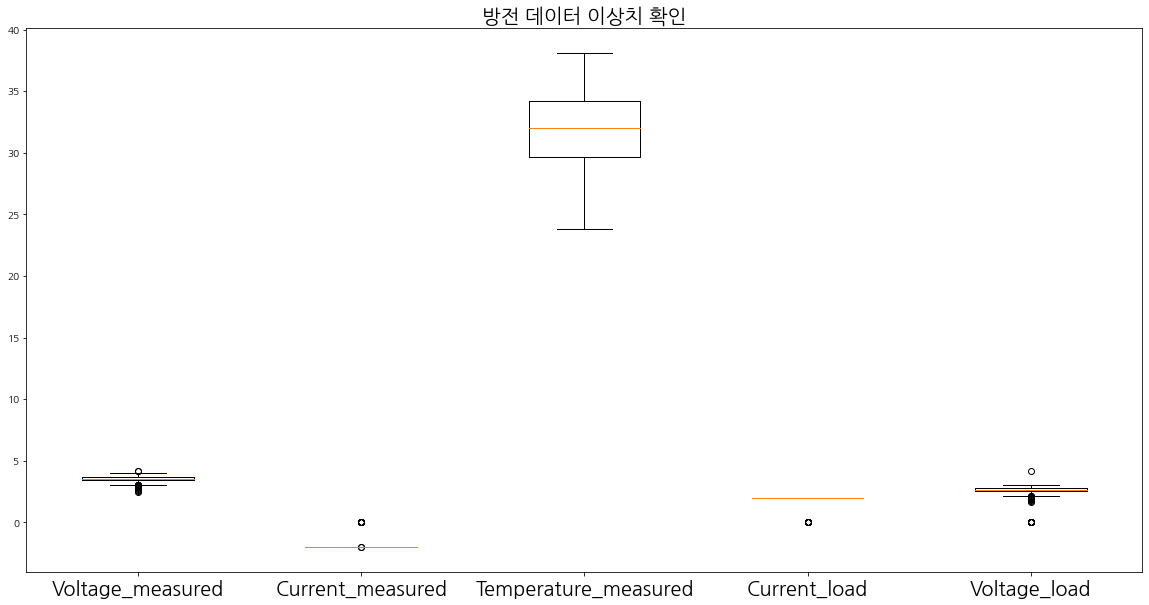

In [611]:
# 이상치 시각화

new_dis = df_dis.set_index("Time", drop=True)

fig, ax = plt.subplots(1,1, figsize=(20,10))
x = np.arange(len(list(new_dis.columns)))
ax.boxplot(new_dis)
ax.set_title("방전 데이터 이상치 확인", fontsize=20)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(new_dis.columns, fontsize=20)

In [612]:
Outliers = detect_outliers(new_dis, 1, list(new_dis.columns))

In [613]:
Outliers 

{'Voltage_measured': array([4.18810865, 4.18819594, 3.02973854, 3.00230901, 2.97228654,
        2.93789002, 2.89860098, 2.85284714, 2.79918822, 2.73540907,
        2.65965764, 2.57086491, 2.47216084, 2.86109734, 2.91988679,
        2.95599048, 2.98285836, 3.00468716, 3.02314578, 3.03929258,
        3.05323034]),
 'Current_measured': array([ 1.30667342e-04,  1.45908061e-03, -2.01045983e+00, -2.00962023e+00,
        -2.00838894e+00, -2.00704803e+00, -2.00746628e+00, -2.00937714e+00,
        -2.01162789e+00, -2.00944122e+00, -2.00950310e+00, -2.01080667e+00,
        -2.00928376e+00,  1.32404365e-03,  6.21856832e-04,  9.45763872e-04,
         8.11502480e-04,  1.06156977e-03, -5.73616307e-04, -1.46579498e-03,
        -2.43341458e-03]),
 'Current_load': array([6.0000e-04, 6.0000e-04, 1.9990e+00, 1.9988e+00, 1.9990e+00,
        1.9990e+00, 1.9990e+00, 1.9990e+00, 1.9990e+00, 1.9990e+00,
        1.9990e+00, 1.9990e+00, 1.9990e+00, 6.0000e-04, 6.0000e-04,
        6.0000e-04, 6.0000e-04, 6.0000e